In [21]:
# display, transform, read, split ...
import numpy as np
import matplotlib.pyplot as plt
import splitfolders

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import  Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Dropout is a regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
from tensorflow.keras.layers import Dropout, BatchNormalization

In [22]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,       # Rotate the image by up to 20 degrees
    width_shift_range=0.2,   # Shift the image width by up to 20% of the width
    height_shift_range=0.2,  # Shift the image height by up to 20% of the height
    shear_range=0.2,         # Shear angle in a counter-clockwise direction in degrees
    zoom_range=0.2,          # Zoom in/out by up to 20%
    horizontal_flip=True,    # Flip the image horizontally
    fill_mode='nearest'      # Fill in pixels that are empty after transformation
)


test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# define classes name
class_names = ['Anger and aggression','anxiety','happy','sad']

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory="./anamelClassification.v1i.multiclass/train",  # Path to the directory containing the training dataset
    classes=class_names,             # List of class names (subdirectory names) to use for classification
    target_size=(224, 224),          # Resize all images to 224x224 pixels
    batch_size=32,                   # Number of images to return in each batch
    class_mode="categorical",        # The type of classification problem ('categorical' indicates multi-class classification)
)
# test data
test_generator = test_datagen.flow_from_directory( 
    directory="./anamelClassification.v1i.multiclass/test", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="categorical", 

)
# validation data
valid_generator = val_datagen.flow_from_directory( 
    directory="./anamelClassification.v1i.multiclass/valid/", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="categorical",
     
)

Found 400 images belonging to 4 classes.
Found 50 images belonging to 4 classes.
Found 50 images belonging to 4 classes.


In [23]:
# ResNet50 model
resnet_50 = ResNet50(
    include_top=False,  # Exclude the fully connected (dense) layers on top of the network.
    weights='imagenet', # Load weights pre-trained on the ImageNet dataset.
    input_shape=(224, 224, 3) # Specify the input shape of the images: 224x224 pixels with 3 color channels (RGB).
)
# This means that the weights of these layers will not be updated during training.
for layer in resnet_50.layers:
    layer.trainable = False
    x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = layers.Dense(4, activation='softmax')(x)

# Create the final model
# The inputs are from ResNet50, and the outputs are the predictions
model = Model(inputs=resnet_50.input, outputs=predictions)

In [6]:
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
    
    return model.fit(train_generator,
                     validation_data=valid_generator,
                     epochs=epochs,
                     batch_size=batch_size,
                     callbacks=[early_stopping, reduce_lr])

In [24]:
model_history = trainModel(model = model, epochs = 50, optimizer = "Adam")


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.3686 - loss: 1.8880 - val_accuracy: 0.6200 - val_loss: 0.9033 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8368 - loss: 0.4705 - val_accuracy: 0.8800 - val_loss: 0.3854 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9144 - loss: 0.1907 - val_accuracy: 0.9200 - val_loss: 0.3664 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9496 - loss: 0.1207 - val_accuracy: 0.8600 - val_loss: 0.2791 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9666 - loss: 0.1032 - val_accuracy: 0.9000 - val_loss: 0.2287 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9702 - loss: 0.0594 - val_accuracy: 0.9000 - val_loss: 0.1656 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9850 - loss: 0.0548 - val_accuracy: 

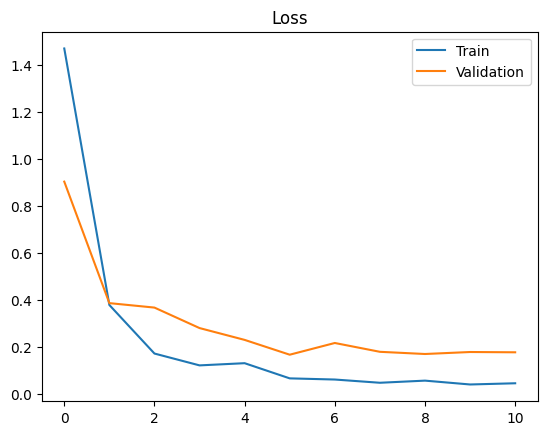

In [25]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

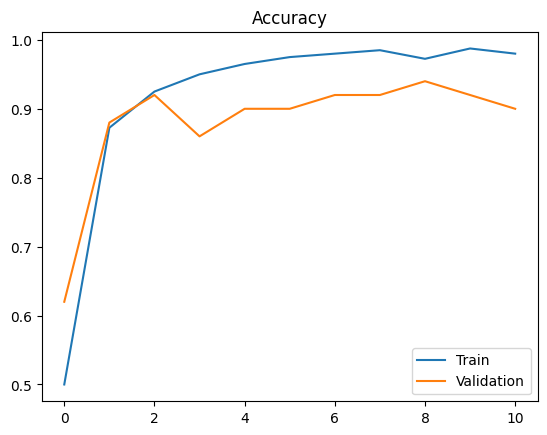

In [26]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [27]:
test_loss, test_acc = model.evaluate(test_generator)
print("The best accuracy is: ", test_acc*100)
print("The test loss is: ", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8546 - loss: 0.3432
The best accuracy is:  86.00000143051147
The test loss is:  0.32618647813796997


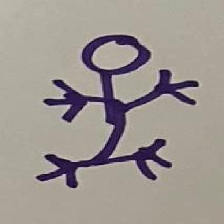

In [28]:
img = tf.keras.preprocessing.image.load_img('./anamelClassification.v1i.multiclass/test/Anger and aggression/photo_82_2024-04-05_12-16-52_jpg.rf.218c300be1d0544662f84acd899b6908.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img


In [29]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
# transform classes number into classes name
class_names[class_id.item()]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[[9.4139302e-01 8.7193452e-04 5.4636803e-02 3.0982443e-03]]


'Anger and aggression'

In [30]:
# Fine-tuning: Unfreeze deeper layers of ResNet50
for layer in resnet_50.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# Train the model again
fine_tune_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.9681 - loss: 0.0857 - val_accuracy: 0.9000 - val_loss: 0.1598 - learning_rate: 1.0000e-05
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9811 - loss: 0.0536 - val_accuracy: 0.9000 - val_loss: 0.1724 - learning_rate: 1.0000e-05
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9707 - loss: 0.0669 - val_accuracy: 0.9000 - val_loss: 0.1884 - learning_rate: 1.0000e-05
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9972 - loss: 0.0389 - val_accuracy: 0.9000 - val_loss: 0.1899 - learning_rate: 1.0000e-05
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9722 - loss: 0.0657 - val_accuracy: 0.9200 - val_loss: 0.1975 - learning_rate: 1.0000e-05
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9854 - loss: 0.0610 - val_accuracy: 0.9200 - val_loss: 0.1943 - learning_rate: 1.0000e-05


In [33]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("The best accuracy is: ", test_acc * 100)
print("The test loss is: ", test_loss)



2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8650 - loss: 0.2889
The best accuracy is:  86.00000143051147
The test loss is:  0.3273801803588867


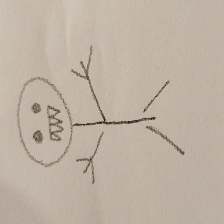

In [35]:
img = tf.keras.preprocessing.image.load_img('./anamelClassification.v1i.multiclass/test/Anger and aggression/IMG-20240403-WA0051_jpg.rf.22befa29342a0cdb271b0a3dd2a23b7e.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img

In [36]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
# transform classes number into classes name
class_names[class_id.item()]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[0.73847914 0.00536942 0.24946919 0.00668231]]


'Anger and aggression'